In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データセットの読み込み
train_data = pd.read_csv('../data/input/train.csv')
test_data = pd.read_csv('../data/input/test.csv')

# train_dataとtest_dataの連結
test_data['Survived'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


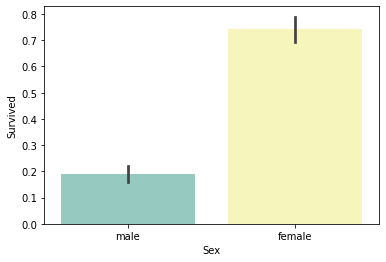

In [13]:
df.info()

# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')
plt.show()

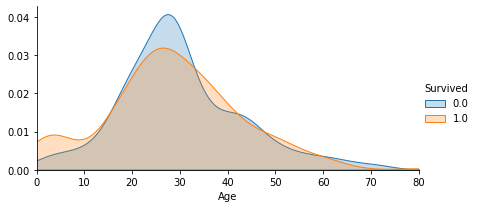

In [14]:
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]
#print(X)
#print(y)

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

<AxesSubplot:xlabel='Title', ylabel='Survived'>

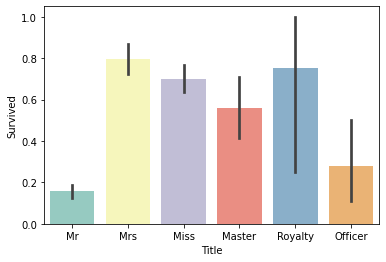

In [15]:
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

In [16]:
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,FamilyGroup
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,2


In [18]:
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

1.000000    113
0.000000     32
0.750000      2
0.500000      1
0.333333      1
0.142857      1
Name: Survived, dtype: int64


In [19]:
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64


In [20]:
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

Dead_list =  {'Jussila', 'Barbara', 'Van Impe', 'Strom', 'Bourke', 'Robins', 'Rice', 'Palsson', 'Ilmakangas', 'Skoog', 'Danbom', 'Goodwin', 'Zabour', 'Elias', 'Attalah', 'Olsson', 'Sage', 'Oreskovic', 'Vander Planke', 'Rosblom', 'Cacic', 'Turpin', 'Johnston', 'Canavan', 'Boulos', 'Arnold-Franchi', 'Lobb', 'Panula', 'Lefebre', 'Lahtinen', 'Ford', 'Caram'}
Survived_list =  {'Jussila', 'Bradley', 'Beckwith', 'Chambers', 'Harder', 'Kimball', 'Frolicher-Stehli', 'Daly', 'Bishop', 'Nakid', 'Goldenberg', 'Cardeza', 'Jonsson', 'Taylor', 'Greenfield', 'McCoy', 'Dick', 'Frauenthal', 'Duff Gordon', 'Moubarek', 'Beane'}


In [21]:
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

In [22]:
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

In [23]:
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

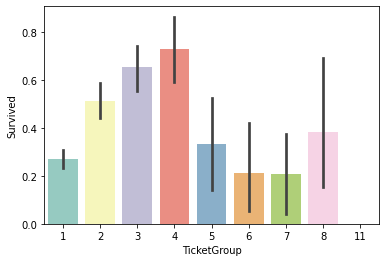

In [24]:
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()

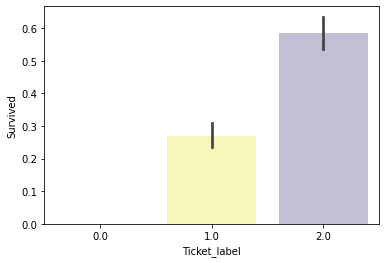

In [25]:
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

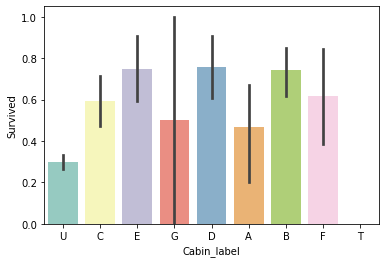

In [26]:
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

In [27]:
df['Embarked'] = df['Embarked'].fillna('S') 


In [28]:
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)

clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


mean_score =  0.8395006242197255
mean_std =  0.049770983038016456


In [30]:
mask= select.get_support()

# 項目のリスト
list_col = list(df.columns[1:])

# 項目別の採用可否の一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

# シェイプの確認
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

No1 Pclass = True
No2 Age = True
No3 Fare = True
No4 Family_label = True
No5 Ticket_label = True
No6 Sex_female = True
No7 Sex_male = True
No8 Embarked_C = True
No9 Embarked_Q = False
No10 Embarked_S = True
No11 Title_Master = True
No12 Title_Miss = True
No13 Title_Mr = True
No14 Title_Mrs = True
No15 Title_Officer = False
No16 Title_Royalty = True
No17 Cabin_label_A = False
No18 Cabin_label_B = True
No19 Cabin_label_C = True
No20 Cabin_label_D = True
No21 Cabin_label_E = True
No22 Cabin_label_F = True
No23 Cabin_label_G = False
No24 Cabin_label_T = False
No25 Cabin_label_U = True
X.shape=(891, 25), X_selected.shape=(891, 20)


In [31]:
PassengerId=test_data['PassengerId']
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("my_submission.csv", index=False)